# ECES 681 - Computer Vision

## Homework 3

### Problem 1:



Print out training losses and train and val set
accuracy as it trains. After training concludes, also make a plot of the training losses as well as the training
and validation-set accuracy of the model during training.

In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, random_split


### Load CIFAR-10 Dataset
Load CIFAR-10 dataset for image classification. This dataset consists of 32 × 32 RGB images of 10 different categories.

In [16]:
# Load the CIFAR10 dataset
transform = transforms.ToTensor()

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split the training dataset into training and validation sets
generator = torch.Generator().manual_seed(42)
train_set, val_set = random_split(train_dataset, [40000, 10000],generator=generator)

# Dataloaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Define Network Architecture
This network has two FC layers with one ReLU activation layer: input -> FC layer -> ReLU layer -> FC
layer -> scores. Write two_layer_net.ipynb function


In [17]:
#  Define Network Architecture
class TwoLayerNet(nn.Module):
    """A two-layer fully connected neural network."""
    def __init__(self, input_dim=3072, hidden_dim=100, num_classes=10):
        """
        Args:
            input_dim (int): Size of the input vector (default 3072 for CIFAR-10).
            hidden_dim (int): Number of neurons in the hidden layer.
            num_classes (int): Number of output classes.
        """
        super().__init__()
        # Fully connected layer 1
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # ReLU activated Layer
        self.relu = nn.ReLU()
        # Fully connected layer 2
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
         """
        Defines the forward pass through the network.

        Args:
            x (Tensor): Input tensor of shape (batch_size, 3, 32, 32)

        Returns:
            Tensor: Output scores of shape (batch_size, num_classes)
        """
        # Flatten the tensor
         x = x.view(x.size(0), -1)
         x = self.fc1(x)
         # Apply ReLU activation
         x = self.relu(x)
         return self.fc2(x)

In [18]:
# Define a function to handle calculating the accuracy and loss of the model
def evaluate_model(model, data_loader, criterion):
    """
    Evaluates the model's average loss and accuracy on a dataset.

    Args:
        model (nn.Module): The trained model to evaluate.
        data_loader (DataLoader): DataLoader for validation or test set.
        criterion (nn.Module): Loss function used (e.g., CrossEntropyLoss).

    Returns:
        tuple: (average_loss, accuracy) for the dataset
    """
    model.eval() # Set the model to evaluation mode
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad(): # Disable gradient computation for speed
        for images, labels in data_loader: # Loop over validation or test data in batches
            outputs = model(images) # Perform forward pass through model for predicted scores
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1) #  Choose index of highest score for each sample (predicted class)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


### Train the Two-Layer Network with Loss and L2 Regularization
Initialize the two-layer network and the optimizer using stochastic gradient descent, implement a training loop for training.


The loss should be the sum of two terms:  
• A data loss term, which is the softmax loss between the model’s predicted scores and the ground-truth
image labels.  
• A regularization loss term, which penalizes the L2 norm of the weight matrices of all the fully-connected
layers of the model. You should not apply L2 regularization to the biases.

In [19]:
# Initialize the model, loss function, and optimizer
model = TwoLayerNet(input_dim=32*32*3, hidden_dim=100, num_classes=10)

learning_rate = 0.001
# weight_decay parameter in torch automatically applies L2 regularization
# to weights only
weight_decay = 0.001

# Cross entropy loss deals with softmax loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [20]:
# Training configuration
num_epochs = 10
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()  # Enable training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        optimizer.zero_grad()             # Clear previous gradients
        outputs = model(images)           # Forward pass
        loss = criterion(outputs, labels) # Compute loss
        loss.backward()                   # Backpropagation
        optimizer.step()                  # Update weights

        # Accumulate training loss
        running_loss += loss.item() * images.size(0)

        # Compute training accuracy on the fly
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Average training loss and accuracy for this epoch
    avg_train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total

    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Evaluate on validation set
    val_loss, val_acc = evaluate_model(model, val_loader, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Print training progress
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/10 | Train Loss: 2.0455, Train Acc: 0.2705 | Val Loss: 1.9133, Val Acc: 0.3378
Epoch 2/10 | Train Loss: 1.8712, Train Acc: 0.3434 | Val Loss: 1.8259, Val Acc: 0.3549
Epoch 3/10 | Train Loss: 1.8071, Train Acc: 0.3623 | Val Loss: 1.7753, Val Acc: 0.3761
Epoch 4/10 | Train Loss: 1.7611, Train Acc: 0.3815 | Val Loss: 1.7363, Val Acc: 0.3929
Epoch 5/10 | Train Loss: 1.7247, Train Acc: 0.3952 | Val Loss: 1.7053, Val Acc: 0.4017
Epoch 6/10 | Train Loss: 1.6934, Train Acc: 0.4072 | Val Loss: 1.6794, Val Acc: 0.4067
Epoch 7/10 | Train Loss: 1.6661, Train Acc: 0.4173 | Val Loss: 1.6754, Val Acc: 0.4070
Epoch 8/10 | Train Loss: 1.6415, Train Acc: 0.4249 | Val Loss: 1.6368, Val Acc: 0.4255
Epoch 9/10 | Train Loss: 1.6191, Train Acc: 0.4346 | Val Loss: 1.6282, Val Acc: 0.4271
Epoch 10/10 | Train Loss: 1.6009, Train Acc: 0.4414 | Val Loss: 1.6078, Val Acc: 0.4391


### Plot the Loss and Accuracy

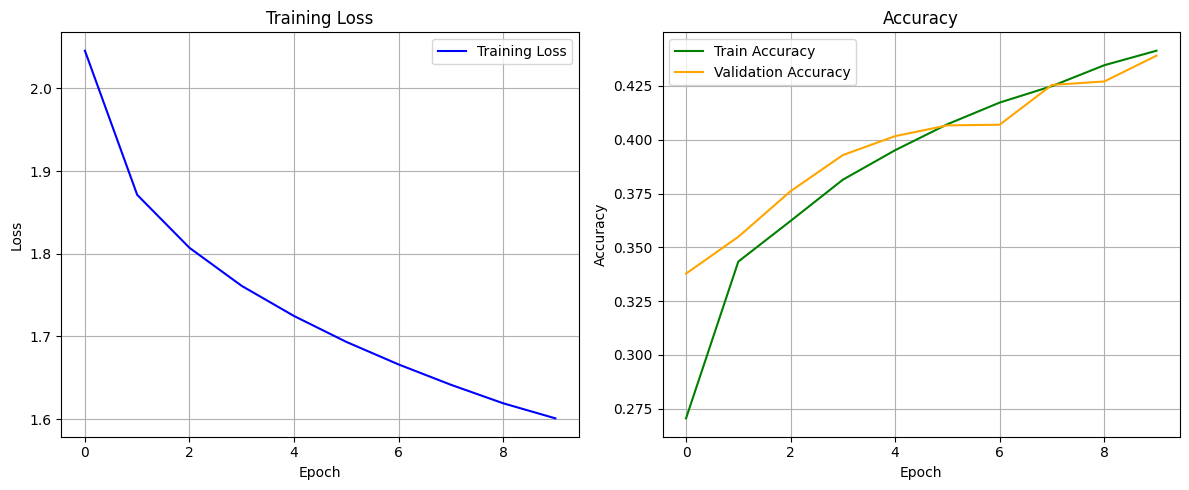

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.grid(True)
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='green')
plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


Best Model Hyperparameters:

Validation Accuracy: 43.91%

- num_train: 40,000 images
- hidden_dim: 100
- batch_size: 64
- num_epochs: 10  
- learning_rate: 0.001
- reg: 0.001

You will need to tune the hyperparameters of your model in order to improve it. Try changing the
hyperparameters of the model. You can consider changing any of the following hyperparameters:  

- num_train: The number of images to use for training
- hidden_dim: The width of the hidden layer of the model
- batch_size: The number of examples to use in each minibatch during SGD
- num_epochs: How long to train. An epoch is a single pass through the training set.  
- learning_rate: The learning rate to use for SGD  
- reg: The strength of the L2 regularization term  

You should tune the hyperparameters and train a model that achieves at least 40% on the validation
set. In your homework submission, include the loss / accuracy plot for your best model. After tuning
your model, run your best model exactly once on the test set.  
Your model should not take an excessive amount of time to train. For reference, our hyperparameter settings
achieve 42% accuracy on the validation set in less than 1 minute of training on a desktop with an Intel i9
CPU.